<a href="https://colab.research.google.com/github/LiChaidoescode/March-Model-Madness/blob/main/NSDC_March_Madness_Classification_Outline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inset cool name at the end 

In [11]:
import pandas as pd
import math
import sklearn 
import csv
import random
import numpy
import seaborn as sb

The first thing was to import the most recent regular season team-level statistics along team-level box scores for many regular seasons of historical data, starting with the 2003 season (men). 

In [12]:
mm_tourney = pd.read_csv("mmmData/MNCAATourneyDetailedResults.csv")
mm_tourney = mm_tourney.dropna(axis = 0)
mm_tourney.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


In [13]:
mm_regseason = pd.read_csv("mmmData/MRegularSeasonDetailedResults.csv")
mm_regseason = mm_regseason.dropna(axis = 0)
mm_regseason.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [14]:
corrM1 = mm_tourney.corr()
corrM2 = mm_regseason.corr()

<AxesSubplot: >

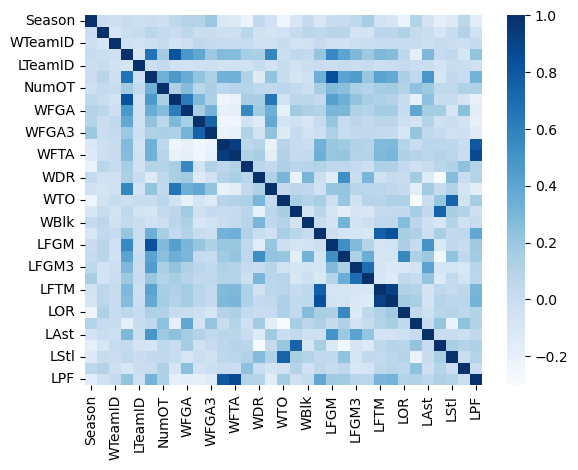

In [18]:
sb.heatmap(corrM1, cmap = "Blues")

<AxesSubplot: >

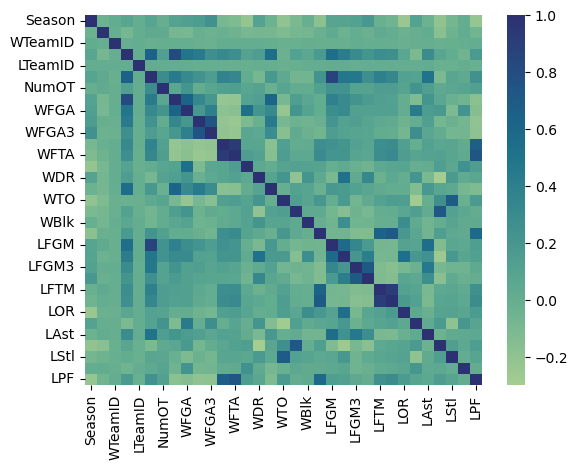

In [17]:
sb.heatmap(corrM2, cmap = "crest")

This correlation matrix only represents numerical values in the data, so things such as team names and rounds in the bracket are not displayed. I followed this step from the NSDC March Madness Classification outline. By inspection, most of the correlated box level scores are quite obvious. For example, field goals made by a losing team is pretty highly correlated with defensive rebounds made by the winning team. Originally, my hopes were to determine which statistics would be the most highly correlated to create a sleeker model. 

After reviewing a number of old march madness projects I decided to take the path taken by Matt Harvey. He used recent team performance and ELO ratings to predict tournament performance. I've used his work as a starting point, updated the data used, and incorporated additional statistical learning models. According to my research, support vector machines are better for this type of highly variable data. 

In [19]:
base_elo = 1600
team_elos = {}  # Reset each year.
team_stats = {}
X = []
y = []
submission_data = []
folder = 'mmmData'
prediction_year = 2023

In [ ]:
# The purpose of this function is to retrieve the ELO ranking of a specific team. 
# If an error occurs on the return, the function retrives the previous season's ending
# value. If an error occurs there it assisngs a base elo ranking. 
def get_elo(season, team):
    try:
        return team_elos[season][team]
    except:
        try:
            # Get the previous season's ending value.
            team_elos[season][team] = team_elos[season-1][team]
            return team_elos[season][team]
        except:
            # Get the starter elo.
            team_elos[season][team] = base_elo
            return team_elos[season][team]

In [ ]:
def calc_elo(win_team, lose_team, season):
    winner_rank = get_elo(season, win_team)
    loser_rank = get_elo(season, lose_team)

    """
    This is originally from from:
    http://zurb.com/forrst/posts/An_Elo_Rating_function_in_Python_written_for_foo-hQl
    """
    rank_diff = winner_rank - loser_rank
    exp = (rank_diff * -1) / 400
    odds = 1 / (1 + math.pow(10, exp))
    if winner_rank < 2100:
        k = 32
    elif winner_rank >= 2100 and winner_rank < 2400:
        k = 24
    else:
        k = 16
    new_winner_rank = round(winner_rank + (k * (1 - odds)))
    new_rank_diff = new_winner_rank - winner_rank
    new_loser_rank = loser_rank - new_rank_diff

    return new_winner_rank, new_loser_rank


In [ ]:
def get_stat(season, team, field):
    try:
        l = team_stats[season][team][field]
        return sum(l) / float(len(l))
    except:
        return 0

In [ ]:
def predict_winner(team_1, team_2, model, season, stat_fields):
    features = []

    # Team 1
    features.append(get_elo(season, team_1))
    for stat in stat_fields:
        features.append(get_stat(season, team_1, stat))

    # Team 2
    features.append(get_elo(season, team_2))
    for stat in stat_fields:
        features.append(get_stat(season, team_2, stat))

    return model.predict_proba([features])

In [ ]:
def update_stats(season, team, fields):
    """
    This accepts some stats for a team and udpates the averages.
    First, we check if the team is in the dict yet. If it's not, we add it.
    Then, we try to check if the key has more than 5 values in it.
        If it does, we remove the first one
        Either way, we append the new one.
    If we can't check, then it doesn't exist, so we just add this.
    Later, we'll get the average of these items.
    """
    if team not in team_stats[season]:
        team_stats[season][team] = {}

    for key, value in fields.items():
        # Make sure we have the field.
        if key not in team_stats[season][team]:
            team_stats[season][team][key] = []

        if len(team_stats[season][team][key]) >= 9:
            team_stats[season][team][key].pop()
        team_stats[season][team][key].append(value)

In [ ]:
def build_team_dict():
    team_ids = pd.read_csv(folder + '/Teams.csv')
    team_id_map = {}
    for index, row in team_ids.iterrows():
        team_id_map[row['Team_Id']] = row['Team_Name']
    return team_id_map

In [ ]:
def build_season_data(all_data):
    # Calculate the elo for every game for every team, each season.
    # Store the elo per season so we can retrieve their end elo
    # later in order to predict the tournaments without having to
    # inject the prediction into this loop.
    print("Building season data.")
    for index, row in all_data.iterrows():
        # Used to skip matchups where we don't have usable stats yet.
        skip = 0

        # Get starter or previous elos.
        team_1_elo = get_elo(row['Season'], row['Wteam'])
        team_2_elo = get_elo(row['Season'], row['Lteam'])

        # Add 100 to the home team (# taken from Nate Silver analysis.)
        if row['Wloc'] == 'H':
            team_1_elo += 100
        elif row['Wloc'] == 'A':
            team_2_elo += 100

        # We'll create some arrays to use later.
        team_1_features = [team_1_elo]
        team_2_features = [team_2_elo]

        # Build arrays out of the stats we're tracking..
        for field in stat_fields:
            team_1_stat = get_stat(row['Season'], row['Wteam'], field)
            team_2_stat = get_stat(row['Season'], row['Lteam'], field)
            if team_1_stat is not 0 and team_2_stat is not 0:
                team_1_features.append(team_1_stat)
                team_2_features.append(team_2_stat)
            else:
                skip = 1

        if skip == 0:  # Make sure we have stats.
            # Randomly select left and right and 0 or 1 so we can train
            # for multiple classes.
            if random.random() > 0.5:
                X.append(team_1_features + team_2_features)
                y.append(0)
            else:
                X.append(team_2_features + team_1_features)
                y.append(1)

        # AFTER we add the current stuff to the prediction, update for
        # next time. Order here is key so we don't fit on data from the
        # same game we're trying to predict.
        if row['Wfta'] != 0 and row['Lfta'] != 0:
            stat_1_fields = {
                'score': row['Wscore'],
                'fgp': row['Wfgm'] / row['Wfga'] * 100,
                'fga': row['Wfga'],
                'fga3': row['Wfga3'],
                '3pp': row['Wfgm3'] / row['Wfga3'] * 100,
                'ftp': row['Wftm'] / row['Wfta'] * 100,
                'or': row['Wor'],
                'dr': row['Wdr'],
                'ast': row['Wast'],
                'to': row['Wto'],
                'stl': row['Wstl'],
                'blk': row['Wblk'],
                'pf': row['Wpf']
            }
            stat_2_fields = {
                'score': row['Lscore'],
                'fgp': row['Lfgm'] / row['Lfga'] * 100,
                'fga': row['Lfga'],
                'fga3': row['Lfga3'],
                '3pp': row['Lfgm3'] / row['Lfga3'] * 100,
                'ftp': row['Lftm'] / row['Lfta'] * 100,
                'or': row['Lor'],
                'dr': row['Ldr'],
                'ast': row['Last'],
                'to': row['Lto'],
                'stl': row['Lstl'],
                'blk': row['Lblk'],
                'pf': row['Lpf']
            }
            update_stats(row['Season'], row['Wteam'], stat_1_fields)
            update_stats(row['Season'], row['Lteam'], stat_2_fields)

        # Now that we've added them, calc the new elo.
        new_winner_rank, new_loser_rank = calc_elo(
            row['Wteam'], row['Lteam'], row['Season'])
        team_elos[row['Season']][row['Wteam']] = new_winner_rank
        team_elos[row['Season']][row['Lteam']] = new_loser_rank

    return X, y

We can see from this that there are some teams that show up more frequently in the bracket than other teams. Depending on how you look at this, you may want to include the team name in your modeling, you may not. In this case, I chose to read this as some teams have more experience in the post-season that may benefit them, and I am including that in the machine learning aspect of this problem.

Next, we need to convert TEAM and CONF variables to integer values because most built-in classification methods cannot handle categorical/textual data. 
<br />
<br />
The best way to do this is to create dummy variables. Dummy variables basically are booleans that replace textual data. If you have a column called "Letters" and the values are [a,b,c], then get_dummies() changes that column into three columns where there is a 1 either in the a, b, or c column that represents the categorical value for that row.

In [ ]:
postseason = mm['POSTSEASON']
mm = mm.drop('POSTSEASON', axis = 1)
dummies = pd.get_dummies(mm)
dummies

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,...,CONF_P12,CONF_Pat,CONF_SB,CONF_SC,CONF_SEC,CONF_SWAC,CONF_Slnd,CONF_Sum,CONF_WAC,CONF_WCC
0,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,...,0,0,0,0,0,0,0,0,0,0
1,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,...,0,0,0,0,0,0,0,0,0,0
2,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,...,0,0,0,0,0,0,0,0,0,0
3,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,...,0,0,0,0,0,0,0,0,0,0
4,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2450,35,26,111.4,87.8,0.9392,50.6,44.5,20.8,19.2,36.1,...,0,0,0,0,0,0,0,0,0,0
2451,35,27,114.4,92.2,0.9229,52.5,46.6,19.5,19.8,35.0,...,1,0,0,0,0,0,0,0,0,0
2452,37,28,104.8,88.6,0.8728,49.3,46.4,21.4,22.0,35.8,...,1,0,0,0,0,0,0,0,0,0
2453,34,24,112.0,96.2,0.8516,51.9,49.3,17.1,21.3,29.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dummies['POSTSEASON'] = postseason

Then we want to select any variables that we do not think will be helpful. In this case, I am choosing to remove the year variables, as I only want to focus on a team's game stats, and not the year that they took place, in order to predict how far teams will go long term in the game. You can select what variables you want to include in your model by thinking through your assumptions about what variables are most highly correlated. You can even use a correlation matrix to best determine the highest correlations between each variable and your target variable.

In [ ]:
mm = dummies.drop('YEAR', axis = 1)

We then want to split into training and testing. Because there might be some order imposed on your dataset to start with, shuffling the data helps to remove that order so that a model doesn't accidentally learn it.

In [ ]:
X = mm.drop('POSTSEASON', axis = 1)
Y = mm["POSTSEASON"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=104, test_size=0.25, shuffle=True)

Now we want to consider what method of classification we are going to use. There are many different types classification methods. The following are just a subset of them:
- Decision Tree/Random Forest: dataset attributes become nodes or branches of a tree 
    - Pros: works well with both numerical and categorical data, implicitly performs feature selection, not greatly influenced by outliers
    - Cons: not easily interpretable, computationally intensive
- K-Nearest Neighbors: creates groups based off of the k-nearest values to some centroid
    - Pros: very simple, easy to implement for multi-class problems, many distance variables to choose from
    - Cons: very sensitive to outliers, slow and performs worse for higher dimensions of data
- Support Vector Machines: model with associated learning algorithms that analyze data for classifications
    - Pros: works well with clear margin of separation, effective in high dimensions
    - Cons: doesn't perform well on noisy data, no probability estimates

For this demonstration, we are going to work with a random forest algorithm. We need to start by determining what the best parameters are based on our data for our random forest algorithm. To do this we are going to create a pipeline that contains the algorithm and parameters we want to train, followed by a grid search which will test a variety of values for each and return the best fit on the training data.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [ ]:
pipe = Pipeline([['reduction', PCA()], ['classify', RandomForestClassifier()]])
pipe_grid = { 'reduction__n_components': [2, 5, 8, 10], 'classify__n_estimators': [10, 100, 1000], 'classify__criterion': ["gini", "entropy", "log_loss"]}
gs = GridSearchCV(pipe, pipe_grid)
gs.fit(X_train, y_train)
best_parameters = gs.best_params_

In [ ]:
best_parameters

Once we have the best parameters, we want to be able to test our model using our X_test and y_test values. We start by reducing the dimensions of our data using the best computed parameter. We then fit the X_train and y_train data to the RandomForestClassifier with the values that we received from the GridSearchCV best parameters. We then predict on the X_test data to get a prediction for y.

In [ ]:
pca = PCA(n_components = best_parameters['reduction__n_components'])
X_train = pca.fit_transform(X_train)

In [ ]:
model = RandomForestClassifier(n_estimators = best_parameters['classify__n_estimators'], criterion = best_parameters['classify__criterion'])
fitted_model = model.fit(X_train, y_train)
y_predicted = fitted_model.predict(pca.fit_transform(X_test))

Now we want to test how well our algorithm performed on our testing data. We can do this in many different ways. One way is by computing the accuracy and precision scores using the sklearn.metrics library. The definition of both are as follows:
- Accuracy Score: an evaluation metric that measures the number of correct predictions made by a model in relation to the total number of predictions made
- Precision Score: the ratio of true positive to the sum of true positive and false positive

Another great way to determine the intricacies of how our model is doing is by generating the confusion matrix which shows both how many times the model got the right answer for each classification, but also how many misclassifications occured per category.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
cm = confusion_matrix(y_test, y_predicted, labels = mm['POSTSEASON'].unique())
acc = accuracy_score(y_test, y_predicted)
prec = precision_score(y_test, y_predicted, average = "weighted")
print("Accuracy Score: " + str(acc))
print("Precision Score: " + str(prec))

In [ ]:
sb.heatmap(cm, annot = True, cmap="Blues", xticklabels = mm['POSTSEASON'].unique(), yticklabels = mm['POSTSEASON'].unique())